# Introduction and Setup

This notebook utilizes a CycleGAN architecture to add vgogh-style to photos. For this tutorial, we will be using the TFRecord dataset. Import the following packages and change the accelerator to TPU.

For more information, check out [TensorFlow](https://www.tensorflow.org/tutorials/generative/cyclegan) and [Keras](https://keras.io/examples/generative/cyclegan/) CycleGAN documentation pages.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

import os
os.system('pip install visualkeras')
import visualkeras

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.8/989.8 kB 15.0 MB/s eta 0:00:00


Number of replicas: 1
2.11.0


# Load in the data

We want to keep our photo dataset and our vgogh dataset separate. First, load in the filenames of the TFRecords.

In [2]:
#GCS_PATH = KaggleDatasets().get_gcs_path()

In [3]:
#Crehe database with both pictures and Van Gogh art, then plug in
VGOGH_FILENAMES = tf.io.gfile.glob('/kaggle/input/van-gogh-tfrecord/images.tfrecord')
print('Van Gogh TFRecord Files:', len(VGOGH_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('/kaggle/input/van-gogh-and-test-pictures/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Van Gogh TFRecord Files: 1
Photo TFRecord Files: 20


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Define the function to extract the image from the files.

In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Let's load in our datasets.

In [6]:
vgogh_ds = load_dataset(VGOGH_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [7]:
example_vgogh = next(iter(vgogh_ds))
example_photo = next(iter(photo_ds))

Let's  visualize a photo example and a vgogh example.

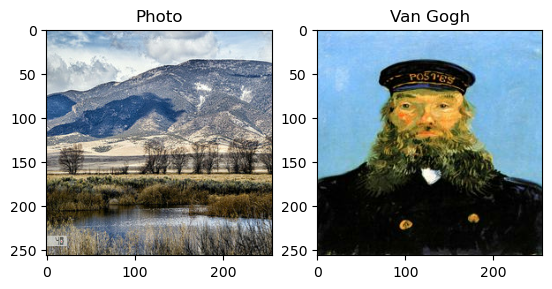

In [8]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Van Gogh')
plt.imshow(example_vgogh[0] * 0.5 + 0.5)

# Build the generator

We'll be using a UNET architecture for our CycleGAN. To build our generator, let's first define our `downsample` and `upsample` methods.

The `downsample`, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an instance normalization instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.

In [9]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    #Change the initializer and stddev?
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    #Number of strides?
    result.add(layers.Conv2D(filters, size - 1, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

`Upsample` does the opposite of downsample and increases the dimensions of the of the image. `Conv2DTranspose` does basically the opposite of a `Conv2D` layer.

In [10]:
def upsample(filters, size, apply_dropout=False):
    #Initializer and stddev?
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    #Strides?
    result.add(layers.Conv2DTranspose(filters, size - 1, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        #Could the dropout value be changed?
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Let's build our generator!

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [11]:
def Generator():
    #Somehow change the number of layers? Def no, the layers matches the input images
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        #Do we need to downsample this much?
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        #Upsample this much?
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]
    #Random initializer and number of strides could be altered?
    initializer = tf.random_normal_initializer(0., 0.01)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS,
                                  #4 represents kernel_size (Should probably be the same everytime this function is called)
                                  2,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  #different activation function?
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    #x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [12]:
def Discriminator():
    #Again, could change the initializer and the stddev
    initializer = tf.random_normal_initializer(0., 0.01)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.01)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    #change the number of strides?
    conv = layers.Conv2D(512, 3, strides=3,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    
    #Strides?
    last = layers.Conv2D(1, 3, strides=3,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [13]:
with strategy.scope():
    vgogh_generator = Generator() # transforms photos to Van Gogh-esque paintings
    photo_generator = Generator() # transforms Van Gogh paintings to be more like photos

    vgogh_discriminator = Discriminator() # differentiates real Van Gogh paintings and generated Van Gogh paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

Since our generators are not trained yet, the generated vgogh-esque photo does not show what is expected at this point.

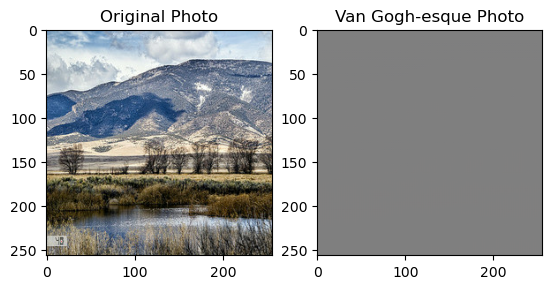

In [14]:
to_vgogh = vgogh_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Van Gogh-esque Photo")
plt.imshow(to_vgogh[0] * 0.5 + 0.5)
plt.show()

# Build the CycleGAN model

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a vgogh painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [15]:
class CycleGan(keras.Model):
    def __init__(
        self,
        vgogh_generator,
        photo_generator,
        vgogh_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = vgogh_generator
        self.p_gen = photo_generator
        self.m_disc = vgogh_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_vgogh, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to vgogh back to photo
            fake_vgogh = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_vgogh, training=True)

            # vgogh to photo back to vgogh
            fake_photo = self.p_gen(real_vgogh, training=True)
            cycled_vgogh = self.m_gen(fake_photo, training=True)

            # generating itself
            same_vgogh = self.m_gen(real_vgogh, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_vgogh = self.m_disc(real_vgogh, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_vgogh = self.m_disc(fake_vgogh, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            vgogh_gen_loss = self.gen_loss_fn(disc_fake_vgogh)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_vgogh, cycled_vgogh, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            
            #generator identity loss
            #id_loss_vgogh = (
            #    self.identity_loss_fn(real_vgogh, same_vgogh)
            #    * self.lambda_cycle
            #    #* self.lamda_identity
            #)
            # evaluates total generator loss
            total_vgogh_gen_loss = vgogh_gen_loss + total_cycle_loss + self.identity_loss_fn(real_vgogh, same_vgogh, self.lambda_cycle)
            #total_vgogh_gen_loss = vgogh_gen_loss + total_cycle_loss + id_loss_vgogh
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            vgogh_disc_loss = self.disc_loss_fn(disc_real_vgogh, disc_fake_vgogh)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        vgogh_generator_gradients = tape.gradient(total_vgogh_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        vgogh_discriminator_gradients = tape.gradient(vgogh_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(vgogh_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(vgogh_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "vgogh_gen_loss": total_vgogh_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "vgogh_disc_loss": vgogh_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [16]:
with strategy.scope():
    #This could be changed
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [17]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [18]:
with strategy.scope():
    #This could be changed?
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [19]:
with strategy.scope():
    #This could also be changed?
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [20]:
with strategy.scope():
    #What would changing these numbers do?
    vgogh_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    vgogh_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        vgogh_generator, photo_generator, vgogh_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = vgogh_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = vgogh_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [22]:
NUMEPOCHS = 2
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((vgogh_ds, photo_ds)),
    epochs=NUMEPOCHS
)

Epoch 1/2


2023-04-28 01:25:22.447324: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


342/342 [==============================] - 144s 254ms/step - vgogh_gen_loss: 7.0062 - photo_gen_loss: 6.9581 - vgogh_disc_loss: 0.5275 - photo_disc_loss: 0.5375
Epoch 2/2
342/342 [==============================] - 87s 253ms/step - vgogh_gen_loss: 4.9168 - photo_gen_loss: 4.8639 - vgogh_disc_loss: 0.5914 - photo_disc_loss: 0.5912


## Visualize all of our models

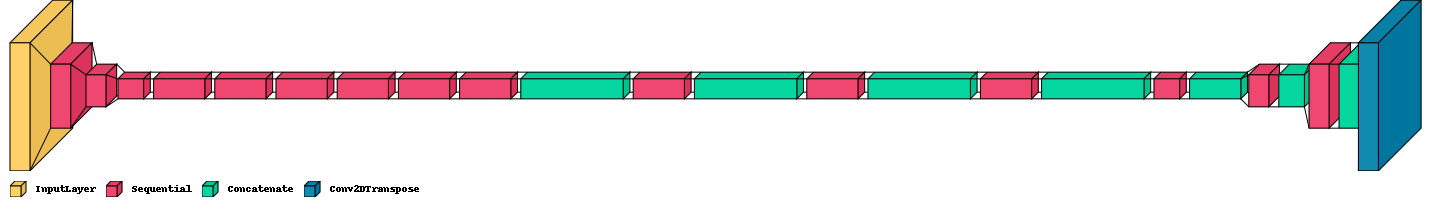

In [23]:
visualkeras.layered_view(vgogh_generator, legend=True, scale_xy=0.5)

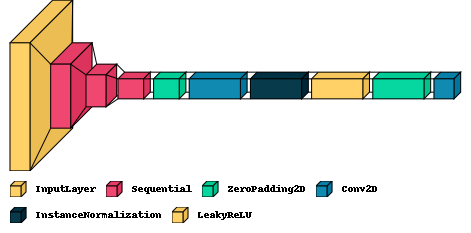

In [24]:
visualkeras.layered_view(vgogh_discriminator, legend=True, scale_xy=0.5)

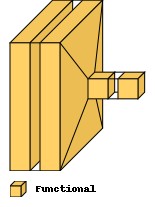

In [25]:
visualkeras.layered_view(cycle_gan_model, legend=True, scale_xy=0.5)

In [26]:
#tf.keras.utils.plot_model(
#    vgogh_generator,
#    to_file='model.png',
#    show_shapes=True,
#    show_dtype=False,
#    show_layer_names=True,
#    rankdir='TB',
#    expand_nested=False,
#    dpi=50,
#    layer_range=None,
#    show_layer_activations=True, 
#)

# Visualize our vgogh-esque photos

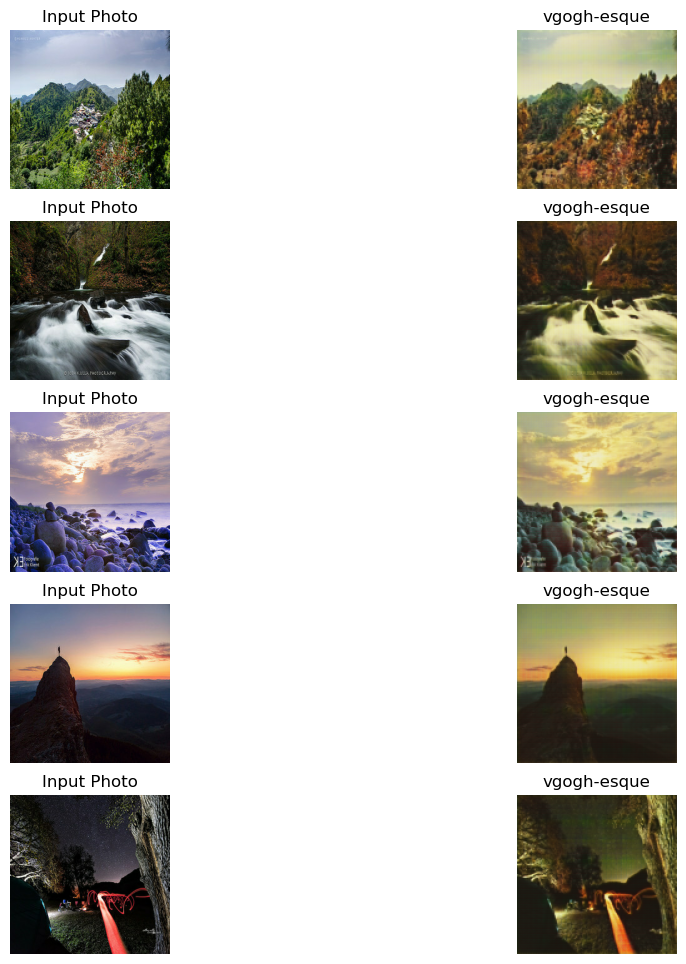

In [27]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.shuffle(342).take(5)):
    prediction = vgogh_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("vgogh-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Epochs vs Loss Charts

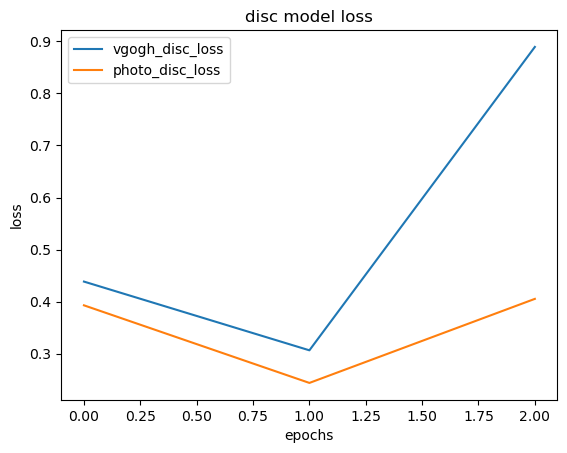

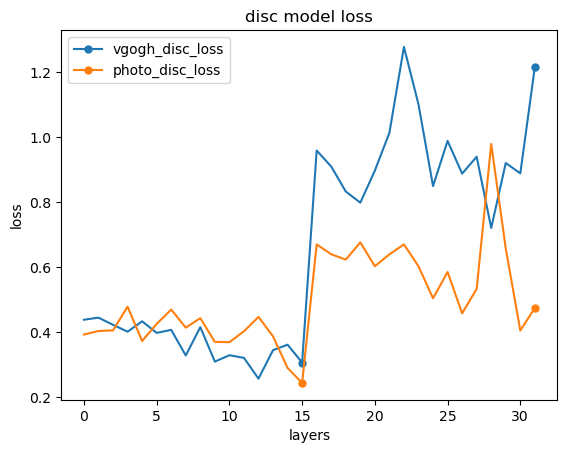

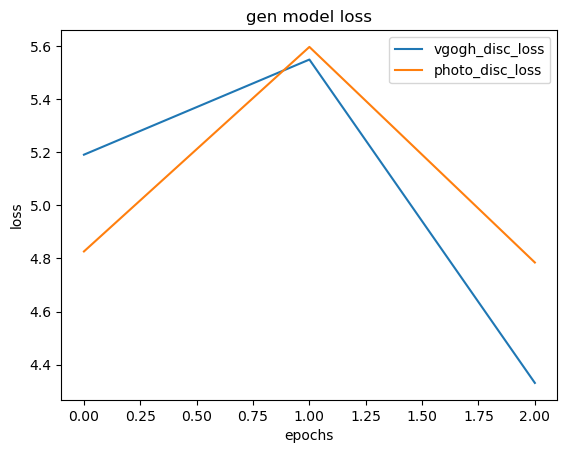

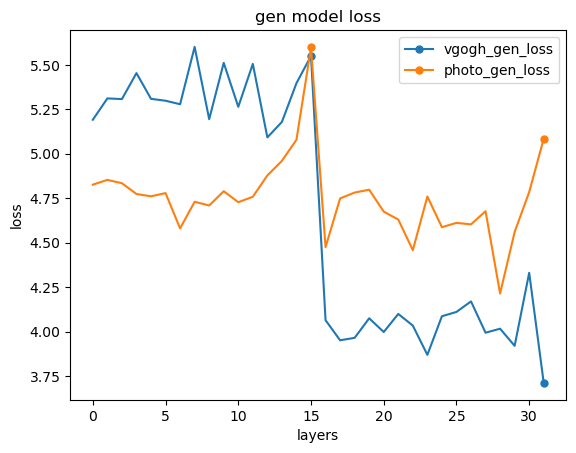

In [28]:
def get_epoch_ends():
    epoch_ends = []
    for i in range(NUMEPOCHS):
        epoch_ends.append((i + 1) * 16 - 1) # subtract 1 to mark the last point of each epoch
    return epoch_ends


#summarize history for discriminator loss

#flatten arrays first
vgogh_disc_loss = np.ravel(history.history['vgogh_disc_loss'])
photo_disc_loss = np.ravel(history.history['photo_disc_loss'])

plt.plot(vgogh_disc_loss[::15])
plt.plot(photo_disc_loss[::15])
plt.title('disc model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['vgogh_disc_loss', 'photo_disc_loss'])
plt.show()

plt.plot(vgogh_disc_loss, markevery=get_epoch_ends(), marker='o', markersize=5)
plt.plot(photo_disc_loss, markevery=get_epoch_ends(), marker='o', markersize=5)
plt.title('disc model loss')
plt.ylabel('loss')
plt.xlabel('layers')
plt.legend(['vgogh_disc_loss', 'photo_disc_loss'])
plt.show()


# summarize history for generator loss

#flatten arrays first
vgogh_gen_loss = np.ravel(history.history['vgogh_gen_loss'])
photo_gen_loss = np.ravel(history.history['photo_gen_loss'])

plt.plot(vgogh_gen_loss[::15])
plt.plot(photo_gen_loss[::15])
plt.title('gen model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['vgogh_disc_loss', 'photo_disc_loss'])
plt.show()

plt.plot(vgogh_gen_loss, markevery=get_epoch_ends(), marker='o', markersize=5)
plt.plot(photo_gen_loss, markevery=get_epoch_ends(), marker='o', markersize=5)
plt.title('gen model loss')
plt.ylabel('loss')
plt.xlabel('layers')
plt.legend(['vgogh_gen_loss', 'photo_gen_loss'])
plt.show()

In [29]:
history.history["photo_gen_loss"]

[array([[[4.826343 , 4.8530383, 4.834448 , 4.773827 ],
         [4.760867 , 4.7789373, 4.5804863, 4.7301145],
         [4.7091193, 4.789541 , 4.727644 , 4.7583704],
         [4.8782644, 4.9601965, 5.078735 , 5.597213 ]]], dtype=float32),
 array([[[4.4750633, 4.748939 , 4.7819076, 4.797932 ],
         [4.674835 , 4.6302137, 4.458174 , 4.759529 ],
         [4.5874934, 4.6114793, 4.603214 , 4.677014 ],
         [4.2145777, 4.560453 , 4.784724 , 5.084511 ]]], dtype=float32)]

In [30]:
photo_gen_loss

array([4.826343 , 4.8530383, 4.834448 , 4.773827 , 4.760867 , 4.7789373,
       4.5804863, 4.7301145, 4.7091193, 4.789541 , 4.727644 , 4.7583704,
       4.8782644, 4.9601965, 5.078735 , 5.597213 , 4.4750633, 4.748939 ,
       4.7819076, 4.797932 , 4.674835 , 4.6302137, 4.458174 , 4.759529 ,
       4.5874934, 4.6114793, 4.603214 , 4.677014 , 4.2145777, 4.560453 ,
       4.784724 , 5.084511 ], dtype=float32)